In [1]:
# Install necessary libraries
%pip install --upgrade --quiet google-cloud-aiplatform ipytest pytest pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [2]:
import IPython
from typing import Optional

app = IPython.Application.instance()
app.kernel.do_shutdown(True)


{'status': 'ok', 'restart': True}

In [18]:
#Import libraries
import vertexai
from vertexai.generative_models import GenerativeModel, SafetySetting
from vertexai.preview.evaluation import EvalTask, MetricPromptTemplateExamples, PointwiseMetric
import ipytest
import pytest
import pandas as pd
import os

In [5]:
# Initialize ipytest for notebook testing
ipytest.autoconfig()
# --- CONFIGURATION ---

PROJECT_ID = "qwiklabs-gcp-01-562fabefbdb6"
REGION = "us-central1"

print(f"Initializing Vertex AI for project: {PROJECT_ID} in {REGION}")
vertexai.init(project=PROJECT_ID, location=REGION)
# Initialize the Model
model = GenerativeModel("gemini-2.5-flash")

Initializing Vertex AI for project: qwiklabs-gcp-01-562fabefbdb6 in us-central1


create two functions utilizing Gemini:
1.  `classify_user_question`: Categorizes input into fixed labels.
2.  `generate_gov_post`: Generates social media content for government announcements.

In [6]:
def classify_user_question(question: str) -> str:
    """
    Classifies a user question into one of four categories:
    Employment, General Information, Emergency Services, or Tax Related.
    """
    prompt = f"""
    You are a government help desk assistant. Classify the following question into EXACTLY one of these categories:
    - Employment
    - General Information
    - Emergency Services
    - Tax Related

    If it does not fit clearly, choose 'General Information'.
    Output ONLY the category name.

    Question: {question}
    Category:
    """

    response = model.generate_content(prompt)
        # Clean up response (remove whitespace/markdown)
    return response.text.strip()

def generate_gov_post(topic: str, event_type: str, specific_details: str) -> str:
    """
    Generates a social media post for a government announcement.
    Args:
        topic: The main subject (e.g., "Snow Storm", "July 4th")
        event_type: The type of event (e.g., "Weather Emergency", "Holiday", "School Closing")
        specific_details: Key info to include (dates, actions to take)
    """
    prompt = f"""
    Create a concise, engaging social media post for a government agency.

    Event Type: {event_type}
    Topic: {topic}
    Details: {specific_details}

    Requirements:
    - Tone should be authoritative yet helpful.
    - Include relevant emojis.
    - Include 2-3 hashtags.
    - Keep it under 280 characters.
    """

    response = model.generate_content(prompt)
    return response.text.strip()

 use `ipytest` to run standard python unit tests within this notebook.

In [7]:
%%ipytest

# Test Suite for Classification Function
def test_classify_employment():
    question = "How do I apply for unemployment benefits?"
    category = classify_user_question(question)
    assert "Employment" in category

def test_classify_emergency():
    question = "My house is on fire, who do I call?"
    category = classify_user_question(question)
    assert "Emergency Services" in category

def test_classify_tax():
    question = "What is the deadline for filing state taxes?"
    category = classify_user_question(question)
    assert "Tax Related" in category

def test_classify_fallback():
    # Vague questions should default to General Information
    question = "What time does the sun set?"
    category = classify_user_question(question)
    assert "General Information" in category

# Test Suite for Generation Function
def test_generate_post_content():
    post = generate_gov_post(
        topic="Blizzard Warning",
        event_type="Weather Emergency",
        specific_details="Stay off roads after 6 PM."
    )

    # Check specific constraints requested in prompt
    assert len(post) > 0
    assert "#" in post # Checks for hashtags
    assert "Stay off roads" in post # Checks for inclusion of details

....F                                                                                        [100%]
============================================= FAILURES =============================================
____________________________________ test_generate_post_content ____________________________________

    def test_generate_post_content():
        post = generate_gov_post(
            topic="Blizzard Warning",
            event_type="Weather Emergency",
            specific_details="Stay off roads after 6 PM."
        )
    
        # Check specific constraints requested in prompt
        assert len(post) > 0
        assert "#" in post # Checks for hashtags
>       assert "Stay off roads" in post # Checks for inclusion of details
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
E       AssertionError: assert 'Stay off roads' in '⚠️ **BLIZZARD WARNING!** ❄️ For your safety, please stay OFF roads after 6 PM tonight. Hazardous conditions are expected. #BlizzardWarning #WinterSafety #StaySafe'

/tmp

Google Evaluation API

In [12]:
# 1. Define the Evaluation Dataset
eval_dataset = pd.DataFrame({
    "question": [
        "Where can I find job listings for the city?",
        "I need to call an ambulance immediately.",
        "How do I file my property taxes online?",
        "When is the city hall open?",
        "Are there jobs available in the sanitation department?"
    ],
    "reference": [ # Ground Truth labels
        "Employment",
        "Emergency Services",
        "Tax Related",
        "General Information",
        "Employment"
    ]
})



In [13]:
# 2. Define the Prompt Templates to Compare

# Prompt A: Direct Classification
prompt_template_a = """
You are a government help desk assistant. Classify the following question into EXACTLY one of these categories:
- Employment
- General Information
- Emergency Services
- Tax Related

Output ONLY the category name.

Question: {question}
Category:
"""

# Prompt B: Detailed/Refined Prompt
prompt_template_b_refined = """
Classify the query into: Employment, General Information, Emergency Services, or Tax Related.
Definitions:
- Employment: Job seeking, benefits, hiring.
- Emergency Services: Police, Fire, Ambulance, life-threatening issues.
- Tax Related: Filing, deadlines, payments.
- General Information: Hours, locations, generic queries.

Query: {question}
Category (Output label only):
"""

In [14]:
#Code (Run Evaluation)

# Define the Metric
# We use "Exact Match" to see if the model predicts the reference label exactly.
task_a = EvalTask(
    dataset=eval_dataset,
    metrics=["exact_match"],
    experiment="gov-classification-basic"
)

task_b = EvalTask(
    dataset=eval_dataset,
    metrics=["exact_match"],
    experiment="gov-classification-detailed"
)

# Run Evaluation for Prompt A
print("Evaluating Prompt A (Basic)...")
results_a = task_a.evaluate(
    model=model,
    prompt_template=prompt_template_a
)

# Run Evaluation for Prompt B
print("Evaluating Prompt B (Detailed)...")
results_b = task_b.evaluate(
    model=model,
    prompt_template=prompt_template_b_refined
)


Evaluating Prompt A (Basic)...


INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'prompt_template': '\nYou are a government help desk assistant. Classify the following question into EXACTLY one of these categories:\n- Employment\n- General Information\n- Emergency Services\n- Tax Related\n\nOutput ONLY the category name.\n\nQuestion: {question}\nCategory:\n', 'model_name': 'publishers/google/models/gemini-2.5-flash'}
INFO:vertexai.preview.evaluation._evaluation:Assembling prompts from the `prompt_template`. The `prompt` column in the `EvalResult.metrics_table` has the assembled prompts used for model response generation.
INFO:vertexai.preview.evaluation._pre_eval_utils:Generating a total of 5 responses from Gemini model gemini-2.5-flash.
100%|██████████| 5/5 [00:00<00:00,  5.80it/s]
INFO:vertexai.preview.evaluation._pre_eval_utils:All 5 responses are successfully generated from model.
INFO:vertexai.preview.evaluation._evaluation:Multithreaded Batch Inference took: 0.86872158400

Evaluating Prompt B (Detailed)...


INFO:vertexai.preview.evaluation.eval_task:Logging Eval experiment evaluation metadata: {'prompt_template': '\nClassify the query into: Employment, General Information, Emergency Services, or Tax Related.\nDefinitions:\n- Employment: Job seeking, benefits, hiring.\n- Emergency Services: Police, Fire, Ambulance, life-threatening issues.\n- Tax Related: Filing, deadlines, payments.\n- General Information: Hours, locations, generic queries.\n\nQuery: {question}\nCategory (Output label only):\n', 'model_name': 'publishers/google/models/gemini-2.5-flash'}
INFO:vertexai.preview.evaluation._evaluation:Assembling prompts from the `prompt_template`. The `prompt` column in the `EvalResult.metrics_table` has the assembled prompts used for model response generation.
INFO:vertexai.preview.evaluation._pre_eval_utils:Generating a total of 5 responses from Gemini model gemini-2.5-flash.
100%|██████████| 5/5 [00:01<00:00,  3.34it/s]
INFO:vertexai.preview.evaluation._pre_eval_utils:All 5 responses are s

--- Results Summary ---
Prompt A Exact Match Score: 0
Prompt B Exact Match Score: 0


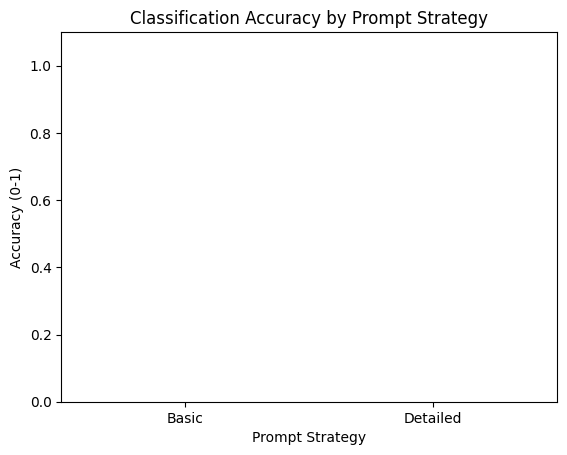


Detailed Results for Detailed Prompt:
Available DataFrame Columns: ['question', 'reference', 'prompt', 'response', 'exact_match/score']


,question,response,reference
0,Where can I find job listings for the city?,Employment,Employment
1,I need to call an ambulance immediately.,Emergency Services,Emergency Services
2,How do I file my property taxes online?,Tax Related,Tax Related
3,When is the city hall open?,General Information,General Information
4,Are there jobs available in the sanitation dep...,Employment,Employment


In [16]:
import matplotlib.pyplot as plt

# --- 1. Get Summary Scores ---
# We use .get() to safely retrieve metrics, defaulting to 0 if missing
score_a = results_a.summary_metrics.get('exact_match', 0)
score_b = results_b.summary_metrics.get('exact_match', 0)

print("--- Results Summary ---")
print(f"Prompt A Exact Match Score: {score_a}")
print(f"Prompt B Exact Match Score: {score_b}")

# --- 2. Visualize Comparison ---
metrics_df = pd.DataFrame({
    'Prompt Strategy': ['Basic', 'Detailed'],
    'Exact Match Score': [score_a, score_b]
})

metrics_df.plot(kind='bar', x='Prompt Strategy', y='Exact Match Score', color=['#4285F4', '#34A853'], legend=False)
plt.title("Classification Accuracy by Prompt Strategy")
plt.ylabel("Accuracy (0-1)")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.show()

# --- 3. Show Detailed Results (The Fix) ---
print("\nDetailed Results for Detailed Prompt:")

# Debug: Print actual columns so you can see them
print("Available DataFrame Columns:", results_b.metrics_table.columns.tolist())

# Define the columns we want to see
# Note: We use 'exact_match' instead of 'metric.exact_match'
desired_cols = ['question', 'response', 'reference', 'exact_match']

# Filter the list to only include columns that actually exist in the dataframe
# This prevents the KeyError if a column name changes slightly in future SDK versions
valid_cols = [col for col in desired_cols if col in results_b.metrics_table.columns]

# Display the table with valid columns
display(results_b.metrics_table[valid_cols])